In [2]:
import os 
os.getcwd()

'/home/shiyi/kaggle_hms/notebooks'

In [3]:
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

train_eeg_dir = Path('../inputs/hms-harmful-brain-activity-classification/train_eegs')
train_spectrogram_dir = Path('../inputs/hms-harmful-brain-activity-classification/train_spectrograms/')

test_dtypes={
    "eeg_label_offset_seconds": "Int64", 
    "spectrogram_label_offset_seconds": "Int64",
    "expert_consensus": "category"
    }

train_df = pd.read_csv('../inputs/hms-harmful-brain-activity-classification/train.csv', dtype=test_dtypes)
display(train_df.head(10))

targets = train_df.columns[-6:] 
print(targets)

submission_df = pd.read_csv('../inputs/hms-harmful-brain-activity-classification/sample_submission.csv')
display(submission_df.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0,353733,0,0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6,353733,1,6,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8,353733,2,8,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18,353733,3,18,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24,353733,4,24,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26,353733,5,26,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30,353733,6,30,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36,353733,7,36,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40,353733,8,40,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0,924234,0,0,1978807404,30539,GPD,0,0,5,0,1,5


Index(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote',
       'other_vote'],
      dtype='object')


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [3]:
print("Unique eeg_id:", train_df['eeg_id'].nunique())
print("Unique spectrogram_id:", train_df['spectrogram_id'].nunique())
print("Unique patient_id:", train_df['patient_id'].nunique())

Unique eeg_id: 17089
Unique spectrogram_id: 11138
Unique patient_id: 1950


In [4]:
df_agrees = train_df.groupby('eeg_id')['expert_consensus'].nunique().to_frame().reset_index(drop=False)
df_agrees = df_agrees.rename(columns={'expert_consensus': 'n_consensus'})
df_agrees = df_agrees.sort_values('n_consensus', ascending=False)
df_agrees

,eeg_id,n_consensus
5874,1460778765,5
8351,2077161557,4
12367,3088095149,4
11982,2989566754,4
10501,2610655079,4
...,...,...
5837,1451105936,1
5838,1451171468,1
5839,1451703032,1
5840,1452595740,1


In [5]:
def get_non_overlap(df_csv, targets, calc_method='simple'):
    # Reference Discussion:
    # https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

    # train and validate using only 1 crop per eeg_id
    # Simple method:
    # - sum the votes for each label
    # - divide by the total number of votes
    # Weighted method:
    # - calculate the confidence for each label
    # - multiply the confidence by the votes for each label
    # - divide by the sum of the confidence for each label
    # - the confidence is calculated considering:
    #   - the number of votes for the label
    #   - the agreement between the experts

    tgt_list = targets.tolist()
    brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
    n_classes = len(brain_activity)

    def calc_confidence(row, n_max, n_classes):
        norm_weight = row['total_experts'] / n_max
        agreement = (row['vote_max'] - row['total_experts']/n_classes) / \
                    (row['total_experts'] - row['total_experts']/n_classes)
        return norm_weight * agreement

    def calc_weighted_votes(grp):

        n_experts_max = grp['total_experts'].max()
        grp['confidence'] = grp.apply(calc_confidence, axis=1, args=(n_experts_max, n_classes))
        grp['confidence_norm'] = grp['confidence'] / grp['confidence'].sum()

        weighted_votes = grp[tgt_list].multiply(grp['confidence_norm'], axis='index').sum()

        return weighted_votes

    agg_dict = {
        'spectrogram_id': 'first',
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'patient_id': 'first',
        'expert_consensus': 'first'
    }
    
    groupby = df_csv.groupby('eeg_id')
    train = groupby.agg(agg_dict)
    train.columns = ['_'.join(col).strip() for col in train.columns.values]
    train.columns = ['spectrogram_id', 'min', 'max', 'patient_id', 'target']

    if calc_method == 'simple':
        vote_sum = groupby[tgt_list].sum()
        class_probs = vote_sum.div(vote_sum.sum(axis=1), axis=0).reset_index(drop=False)

    elif calc_method == 'weighted':
        df_csv['total_experts'] = df_csv[[f"{label}_vote" for label in brain_activity]].sum(axis=1)
        df_csv['vote_max'] = df_csv[[f"{label}_vote" for label in brain_activity]].max(axis=1)
        weighted_votes = df_csv.groupby('eeg_id').apply(calc_weighted_votes, include_groups=False) 
        class_probs = weighted_votes.div(weighted_votes.sum(axis=1), axis=0).reset_index(drop=False)

    train = train.reset_index(drop=False)
    train = train.merge(class_probs, on='eeg_id', how='left')
    
    return train

In [8]:
df_train_simple = get_non_overlap(train_df, targets, calc_method='simple')

df_train_simple.head()

,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0,16,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0,38,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008,1032,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908,908,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0,0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000


In [9]:
df_train = get_non_overlap(train_df, targets, calc_method='weighted')

df_train.head()

,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0,16,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0,38,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008,1032,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908,908,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0,0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000


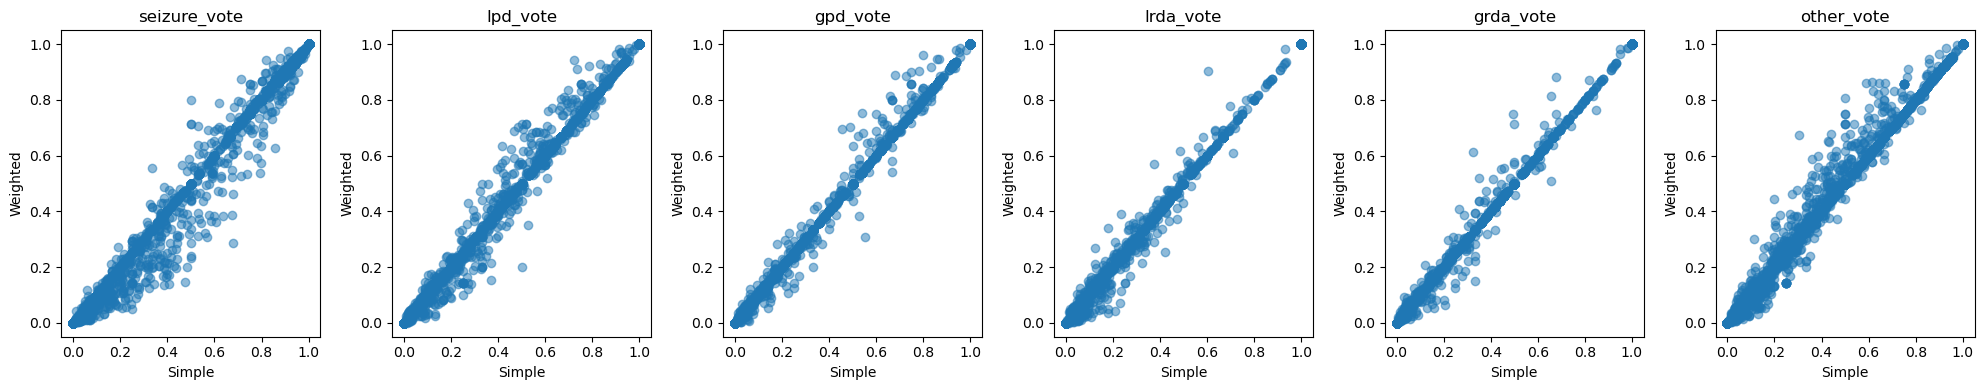

In [13]:
fig, ax = plt.subplots(1, len(targets), figsize=(20, 4))
for i, tgt in enumerate(targets):
    ax[i].scatter(df_train_simple[tgt], df_train[tgt], alpha=0.5)
    ax[i].set_title(tgt)
    ax[i].set_xlabel('Simple')
    ax[i].set_ylabel('Weighted')

fig.tight_layout()
plt.show()

In [12]:
td = train_df.iloc[0:10]

sum_to_one = td[targets].div(td[targets].sum(axis=1), axis=0).sum(axis=1)

(sum_to_one == 1.0).all()

True

In [ ]:
vote_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_df['total_voters'] = train_df[vote_cols].sum(axis=1)

plt.figure(figsize=(10, 6))
plt.hist(train_df['total_voters'], bins=10)
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Voters')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
eeg_id = 1628180742
eeg_df = pd.read_parquet(train_eeg_dir/f"{eeg_id}.parquet")
print(eeg_df.shape)
eeg_df.head()

In [ ]:
spec_id = 789577333
spec_df = pd.read_parquet(train_spectrogram_dir/f"{spec_id}.parquet")
print(spec_df.shape)
spec_df.tail()

In [ ]:
def load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset):

    eeg_df = pd.read_parquet(train_eeg_dir/f"{eeg_id}.parquet")
    start_eeg = eeg_offset * 200
    end_eeg = start_eeg + (200 * 50)

    eeg = eeg_df.iloc[start_eeg:end_eeg,]

    spec_df = pd.read_parquet(train_spectrogram_dir/f"{spec_id}.parquet")
    start_spec = spec_offset
    end_spec = start_spec + 600

    spec = spec_df[(spec_df["time"] <= end_spec) & (spec_df["time"] >= start_spec)]

    return eeg, spec

from scipy.signal import butter, sosfilt

sos = butter(4, [1, 40], btype="bandpass", fs=200, output='sos')

def central_window_eeg(df, window_seconds=10):
    start = df.index[0]
    end = df.index[-1]
    mid = (start + end) / 2
    new_start = int(mid - window_seconds/2 * 200) - start + 1
    new_end = int(mid + window_seconds/2 * 200) - start + 1
    return df.iloc[new_start:new_end]

def plot_eeg(df, bp_filter=True):

    fig, axs = plt.subplots(20, 1, figsize=(15, 10), sharex=True)
    
    for i, ax in enumerate(axs):
        
        if bp_filter:
            ts_signal = sosfilt(sos, df.iloc[:,i])
        else:
            ts_signal = df.iloc[:,i]

        ax.plot(ts_signal, color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
    
    fig.tight_layout()
    plt.show()

def plot_spec(df):

    fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs.flatten(), prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(df[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix, fontsize=12, fontweight="bold")
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(df.iloc[0, 0], df.iloc[-1, 0], (df.iloc[-1, 0]-df.iloc[0, 0])//4))

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency (Hz)")
    for ax in axs[-1, :]:
        ax.set_xlabel("Time (s)")

    fig.tight_layout()
    plt.show()

In [ ]:
choose_row = 2387

eeg_id, spec_id, eeg_offset, spec_offset = train_df.loc[choose_row, ['eeg_id', 'spectrogram_id', 'eeg_label_offset_seconds', 'spectrogram_label_offset_seconds']]

votes = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote" ]

print(f"eeg_id: {eeg_id}, spec_id: {spec_id}, eeg_offset: {eeg_offset}, spec_offset: {spec_offset}")
print(f"patient_id: {train_df.loc[choose_row, 'patient_id']}")
print(f"label_id: {train_df.loc[choose_row, 'label_id']}")
print(f"expert_consensus: {train_df.loc[choose_row, 'expert_consensus']}")
print(f"Votes: ")
for vote in votes:
    print(f"{vote}: {train_df.loc[choose_row, vote]}")


df_eeg, df_spec = load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset)

In [ ]:
df_eeg.head(20)

In [ ]:
df_spec.head(20)

In [ ]:
LL_freq = df_spec.filter(regex="^LL_")
LL_freq.head()

In [ ]:
plot_eeg(central_window_eeg(df_eeg, 10), bp_filter=True)

In [ ]:
plot_spec(df_spec)

In [ ]:
arr_spec = df_spec.iloc[:, 1:].to_numpy().T
arr_spec.shape

In [ ]:
from torchvision.transforms import v2
from torchvision.transforms import functional as F
import torch
import random

class MyCustomTransform(torch.nn.Module):
    def __init__(self, mask_ratio=0.1, max_mask_num=2):
        super(MyCustomTransform, self).__init__()
        self.mask_ratio = mask_ratio
        self.max_mask_num = max_mask_num
    
    def forward(self, image):

        # Assuming image is a tensor of shape [C, H, W]
        _, h, w = image.shape
        
        for _ in range(random.randint(1, self.max_mask_num)):
            image = self._apply_mask(image, h, w)

        return image

    def _apply_mask(self, image, h, w):

        # Calculate max mask width and height based on mask_ratio
        max_mask_width = int(w * self.mask_ratio)
        max_mask_height = int(h * self.mask_ratio)
        
        # Randomly choose the dimension(s) to mask: 0 for cols, 1 for rows, 2 for both
        dim_to_mask = random.randint(0, 2)
        
        # Initialize mask as ones
        mask = torch.ones_like(image)
        
        # Select random start point for masking in both dimensions
        x1 = random.randint(0, w - max_mask_width)
        y1 = random.randint(0, h - max_mask_height)
        
        # Calculate end points ensuring they do not exceed max mask width/height
        x2 = x1 + random.randint(1, max_mask_width)
        y2 = y1 + random.randint(1, max_mask_height)
        
        # Adjust x2 and y2 to not go beyond image bounds
        x2 = min(x2, w)
        y2 = min(y2, h)
        
        if dim_to_mask == 0 or dim_to_mask == 2:
            mask[:, :, x1:x2] = 0
        
        if dim_to_mask == 1 or dim_to_mask == 2:
            mask[:, y1:y2, :] = 0
        
        image_new = image * mask
        
        return image_new


applier = v2.RandomApply(
    transforms=[
        v2.RandomHorizontalFlip(p=.2),
        v2.RandomVerticalFlip(p=.2),
        MyCustomTransform(mask_ratio=0.1)
        ], p=.5)


fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axs[0, 0].imshow(arr_spec, origin="lower", norm="log", cmap="plasma", interpolation="none")
axs[0, 0].set_title("Original")
for i, ax in enumerate(axs.flatten()[1:]):
    arr_spec_transformed = applier(torch.tensor(np.expand_dims(arr_spec, axis=0))).numpy()
    ax.imshow(arr_spec_transformed[0], origin="lower", norm="log", cmap="plasma", interpolation="none")
    ax.set_title(f"Transformed {i+1}")

fig.tight_layout()
plt.show()